# <font color=#cd0000> Propósito principal </font>
- La idea de este librillo es preparar el entorno para realizar pruebas para Seguimiento Ocular a ser clasificado con las series en bruto y LSTM

## <font color=#cd0000> Leyenda </font>
- Los apartados titulados con el código de colores HEX: `#cd0000` serán apartados que tendrán todos los librillos, en concreto, aquellos especificados en el apartado `Síntesis de los criterios usados` del trabajo.
- Los apartados titulados con el código de colores HEX: `#2451ff` serán apartados de conclusiones propias de este librillo resultado de aplicar un estudio personalizado para cada planteamiento.

# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../../../')
os.listdir()


['.git',
 '.gitignore',
 '.gitmodules',
 'data',
 'HeartBeat_tmp_test_data.pkl',
 'HeartBeat_tmp_train_data.pkl',
 'pkl',
 'Pruebas',
 'README.md',
 'smts_implementation',
 'utils']

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [2]:
SEGUIMIENTO_OCULAR_PATH = "data/seguimiento-ocular/Data/Hospital"
SEGUIMIENTO_OCULAR_FOLDERS_ID = range(1, 12+1)

DATA_TO_SAVE = "SegOcular"

PKL_DIR = "pkl/LSTM/SegOcular/"
PKL_NAME = "segocular_LSTM_raw.pkl"

SEED = 1


# <font color=#cd0000> Carga del Dataset </font>

In [3]:
from utils.load_data import import_seguimiento_ocular_dataset

all_data = import_seguimiento_ocular_dataset(
    SEGUIMIENTO_OCULAR_PATH, SEGUIMIENTO_OCULAR_FOLDERS_ID)


In [4]:
all_data.reset_changes()


# <font color=#cd0000> Preprocesamiento </font>

## <font color=#cd0000> Eliminación de datos inválidos y valores atípicos </font>
- No eliminaremos aquellos valores fuera de los percentiles 5 y 95 ante la falta de información.

### <font color=#2451ff> Limpieza de datos </font>
- Eliminaremos todos aquellos valores inválidos con un "0" en alguna de las columnas `*Validity*`.

In [5]:
# Clean data
validity_headers = ['ValidityLeft',
                    'ValidityRight',
                    'PupilValidityLeft',
                    'PupilValidityRight']

all_data.clean_data(criterion='remove', value=0, headers=validity_headers, drop_columns=validity_headers)

## <font color=#2451ff> Reducción de la dimensionalidad </font>
- Eliminamos los atributos redundantes/no informativos (o que puedan sesgar al modelo).

In [6]:
# Reduce data
columns_to_remove = ['GazePointX', 'GazePointY', 'diagnosis', 'Age']
all_data.drop_derived_data_columns(columns_to_remove)


,id,TimeStamp,GazePointXLeft,GazePointYLeft,GazePointXRight,GazePointYRight,PupilSizeLeft,PupilSizeRight,class
0,1-1,704.487,875,549,771,284,2.1565,2.1575,Control
1,1-1,750.040,879,519,796,245,2.0449,2.1528,Control
2,1-1,776.032,898,547,785,316,2.1199,2.1833,Control
3,1-1,831.135,882,563,768,322,2.1039,2.3215,Control
4,1-1,857.075,879,513,789,362,2.0490,2.4636,Control
...,...,...,...,...,...,...,...,...,...
36362,12-3,54379.209,162,808,263,944,2.6453,2.4885,Estudio
36363,12-3,54406.850,136,816,272,969,2.6189,2.4906,Estudio
36364,12-3,54433.946,122,942,191,854,2.5684,2.2774,Estudio
36365,12-3,54460.926,326,918,364,936,2.3562,2.6705,Estudio


## <font color=#2451ff> Eliminación de series cortas </font>
- Ante la limpieza de los datos hemos acabado con series, concretamente, la ``8-1`` (72 muestras) y ``8-2`` (202 muestras), con muy pocas muestras.
  - Las eliminaremos con el fin de no obtener ventanas demasiado pequeñas (72/4 = 18 muestras por ventana)

In [7]:
all_data.derived_data = all_data.derived_data[
    all_data.derived_data['id'] != '8-1']  # 72 samples
all_data.derived_data = all_data.derived_data[
    all_data.derived_data['id'] != '8-2']  # 202 samples


In [8]:
import pandas as pd

# Remaining series
print("Previous number of series: {}".format(
    len(pd.unique(all_data.original_data['id']))))
print("Actual number of series: {}".format(
    len(pd.unique(all_data.derived_data['id']))))

print("Previous largest serie: {}".format(
    all_data.get_largest_serie(all_data.original_data).shape[0]))
print("Actual largest serie: {}".format(
    all_data.get_largest_serie().shape[0]))

print("Previous shortest serie: {}".format(
    all_data.get_shortest_serie(all_data.original_data).shape[0]))
print("Actual shortest serie: {}".format(
    all_data.get_shortest_serie().shape[0]))


Previous number of series: 25
Actual number of series: 23
Previous largest serie: 2113
Actual largest serie: 1901
Previous shortest serie: 967
Actual shortest serie: 768


## <font color=#cd0000> Resoluciones a aplicar </font>
- Como vimos en el análisis en profundidad, mantendremos la resolución actual

In [9]:
# Nothing to see here

# <font color=#cd0000> División en ventanas </font>
- El número de ventanas por serie será de 4 como ya vimos en el análisis en profundidad.

In [10]:
all_data.split_into_windows(n_windows=4)

In [11]:
all_data.get_derived_data_classes_count()

Estudio    60
Control    32
Name: class, dtype: int64

# <font color=#cd0000> Codificación </font>
- Series en bruto

In [12]:
# Nothing to see here

## <font color=#2451ff> Codificación de la clase </font>

In [13]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
all_data.apply_codification_to_class(enc)

# <font color=#2451ff> Particionado inicial de los datos y normalización </font>
- Llevaremos a cabo el particionado empleado por Marta en su TFM: http://hdl.handle.net/10486/697441

In [14]:
import numpy as np
from utils.data_extraction import Data

X_train, X_test, y_train, y_test = all_data.train_test_split(
    criterion='tfm_marta',
    train_size=.8,
    random_state=SEED,
    standardize_columns=all_data.get_derived_data_columns()['attrs'],
    drop_columns=['TimeStamp', 'class']
)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

X_train_Data = Data(X_train)
X_test_Data = Data(X_test)

## <font color=#cd0000> Preparación de los datos </font>

In [15]:
max_sequence_length = max(X_train_Data.get_largest_serie().shape[0],
                          X_test_Data.get_largest_serie().shape[0])

X_train = X_train.drop('id', axis=1).to_numpy()
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

X_test = X_test.drop('id', axis=1).to_numpy()
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


## <font color=#cd0000> Técnicas de balanceo </font>

### <font color=#cd0000> Asignación de pesos a las clases </font>

In [16]:
import numpy as np
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}


# <font color=#cd0000> Diseño de la topología de red </font>

In [47]:
import keras as k
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking

nn = Sequential()

# Number of initial dimensions
# nn.add(LSTM(units=3))
# Number of SegOcular's classes
nn.add(Dense(1, activation='sigmoid'))


## <font color=#cd0000> Compilación de la red </font>

In [48]:
from keras.optimizers import Adam

metrics = [
    k.metrics.CategoricalAccuracy(name="ACC"),
    k.metrics.Precision(name='Prec'),
    k.metrics.Recall(name='Rec'),
    k.metrics.AUC(name='AUC')
]

nn.compile(optimizer=Adam(learning_rate=1e-2), loss='mse', metrics=metrics)


## <font color=#cd0000> Visualización de resultados preliminares </font>

In [49]:
import matplotlib.pyplot as plt


def show_metrics(history):
    for metric in history.history.keys():
        if not metric.startswith('val_'):
            plt.plot(history.history[metric], label=metric)
            plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
            plt.title(metric)
            plt.ylabel('')
            plt.xlabel('Epoch')
            plt.legend(loc="upper left")
            plt.show()


## <font color=#cd0000> Entrenamiento del modelo </font>

Epoch 1/100
57/57 [==============================] - 0s 7ms/step - loss: 0.2969 - ACC: 1.0000 - Prec: 0.6373 - Rec: 0.5048 - AUC: 0.4992 - val_loss: 0.2382 - val_ACC: 1.0000 - val_Prec: 0.6469 - val_Rec: 0.5025 - val_AUC: 0.6173
Epoch 2/100
57/57 [==============================] - 0s 1ms/step - loss: 0.2293 - ACC: 1.0000 - Prec: 0.7019 - Rec: 0.6194 - AUC: 0.6354 - val_loss: 0.2244 - val_ACC: 1.0000 - val_Prec: 0.7153 - val_Rec: 0.6980 - val_AUC: 0.6400
Epoch 3/100
57/57 [==============================] - 0s 1ms/step - loss: 0.2254 - ACC: 1.0000 - Prec: 0.7156 - Rec: 0.6616 - AUC: 0.6558 - val_loss: 0.2229 - val_ACC: 1.0000 - val_Prec: 0.7158 - val_Rec: 0.6823 - val_AUC: 0.6632
Epoch 4/100
57/57 [==============================] - 0s 1ms/step - loss: 0.2220 - ACC: 1.0000 - Prec: 0.7268 - Rec: 0.6606 - AUC: 0.6790 - val_loss: 0.2207 - val_ACC: 1.0000 - val_Prec: 0.7161 - val_Rec: 0.6760 - val_AUC: 0.6780
Epoch 5/100
57/57 [==============================] - 0s 1ms/step - loss: 0.2193 - AC

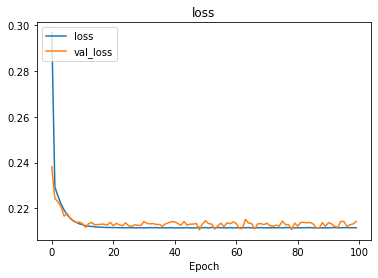

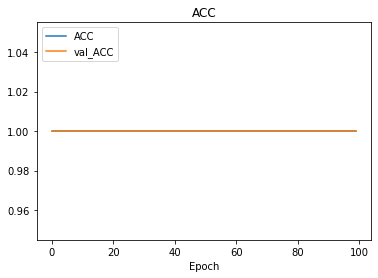

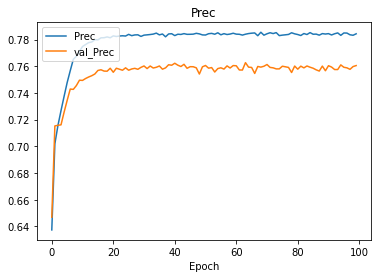

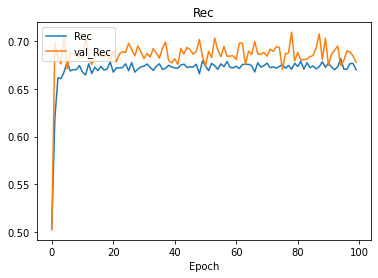

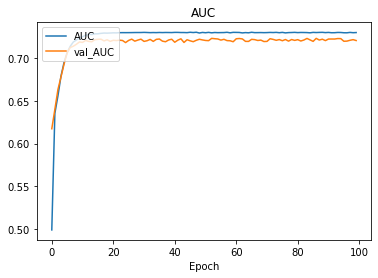

In [50]:
import numpy as np
from keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

epochs = 100

history = nn.fit(X_train, y_train, epochs=epochs,
                 validation_data=(X_test, y_test),
                 batch_size=max_sequence_length,
                 class_weight=class_weights,
                 verbose=1)
nn.summary()
print('\n\n')

y_pred = nn.predict(X_test)
y_pred = y_pred > 0.5

show_metrics(history)


## <font color=#cd0000> Clasificación </font>

In [59]:
y_pred = y_pred.astype('int')
y_pred = enc.inverse_transform(y_pred)
y_real = enc.inverse_transform(y_test)
print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred, zero_division=0))

[[2099 1216]
 [1836 3862]]
              precision    recall  f1-score   support

     Control       0.53      0.63      0.58      3315
     Estudio       0.76      0.68      0.72      5698

    accuracy                           0.66      9013
   macro avg       0.65      0.66      0.65      9013
weighted avg       0.68      0.66      0.67      9013



c:\Users\Javier\anaconda3\envs\tfg_env\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## <font color=#cd0000> Discusión de los resultados </font>
- Dimensionalidad de entrada inicial -> 6
> **IMPORTANTE**
> - Hemos decidido cambiar el optimizador a Adam ya que es un problema con muy pocas clases y, este optimizador, utiliza una tasa de aprendizaje adaptativo que suele ir bien para este tipo de problemas.
> - También hemos decidido cambiar la función de error a un MSE que ha brindado mejores resultados.
- Vamos a estudiar diferentes rangos de hiper-parámetros que podrían darnos alguna pista sobre el rango en el que buscar el mejor clasificador de este tipo:
  - Para una red de, inicialmente, 1 capa oculta puesto que las series del problema no son muy complejas y, además, podríamos correr el riesgo de sobreajustar la red al tener tan pocos ejemplos:
   - Para un `n_units_capa1` de 2 veces la dim_entrada (12) y un `learning_rate` rápido (1e-2) obtenemos resultados bastante mejores que para RandomForest aunque con bastante sobreajuste por lo que probaremos a utilizar un 20% de tasa de Dropout:
   ```
   Confusion matrix:
   [[2546  769]
    [ 867 4831]]

   Classification report:
                  precision    recall  f1-score   support

       Control       0.75      0.77      0.76      3315
       Estudio       0.86      0.85      0.86      5698

      accuracy                           0.82      9013
     macro avg       0.80      0.81      0.81      9013
  weighted avg       0.82      0.82      0.82      9013
   ```
   - Para un `n_units_capa1` de 2 veces la dim_entrada (12), un `learning_rate` rápido (1e-2) y una tasa de Dropout del 20% logramos hacer descender el sobreajuste pero empeoramos ligeramente los resultados, probemos a disminuir la tasa de aprendizaje:
   ```
   Confusion matrix:
   [[2307 1008]
    [ 920 4778]]

   Classification report:
                  precision    recall  f1-score   support

       Control       0.71      0.70      0.71      3315
       Estudio       0.83      0.84      0.83      5698

      accuracy                           0.79      9013
     macro avg       0.77      0.77      0.77      9013
  weighted avg       0.79      0.79      0.79      9013
   ```
   - Para un `n_units_capa1` de 2 veces la dim_entrada (12), un `learning_rate` lento (1e-4) y una tasa de Dropout del 20% parece que quedamos atrapados en un mínimo local, aumentemos aún más el número de neuronas:
   ```
   Confusion matrix:
   [[2304 1011]
    [ 911 4787]]

   Classification report:
                  precision    recall  f1-score   support

        Control       0.72      0.70      0.71      3315
        Estudio       0.83      0.84      0.83      5698

       accuracy                           0.79      9013
      macro avg       0.77      0.77      0.77      9013
   weighted avg       0.79      0.79      0.79      9013
   ```
   - Para un `n_units_capa1` de 4 veces la dim_entrada (24) y un `learning_rate` rápido (1e-2) y Dropout del 20% obtenemos peores resultados ante el aumento de la complejidad del modelo, probemos a disminuir el número de neuronas y eliminar la tasa de Dropout:
   ```
   Confusion matrix:
   [[1970 1345]
    [ 802 4896]]

   Classification report:
                  precision    recall  f1-score   support

        Control       0.71      0.59      0.65      3315
        Estudio       0.78      0.86      0.82      5698

       accuracy                           0.76      9013
      macro avg       0.75      0.73      0.73      9013
   weighted avg       0.76      0.76      0.76      9013
   ```
   - Para un `n_units_capa1` de la mitad de dim_entrada (3) y un `learning_rate` rápido (1e-2) obtenemos mejores resultados y eliminamos el sobreajuste, parece que disminuir la complejidad del modelo favorece en su aprendizaje:
   ```
   Confusion matrix:
   [[2908  407]
    [ 953 4745]]

   Classification report:
                  precision    recall  f1-score   support

        Control       0.75      0.88      0.81      3315
        Estudio       0.92      0.83      0.87      5698

       accuracy                           0.85      9013
      macro avg       0.84      0.85      0.84      9013
   weighted avg       0.86      0.85      0.85      9013
   ```

## <font color=#cd0000> Conclusiones </font>
- Como podemos observar cuanta menor complejidad en la red mejor clasifica
- Rango orientativo:
  - `n_units`: [2, 12]
  - `learning_rate`: [1e-2, 8e-3, 7e-3, 5e-3, 1e-3]
  - Sin tasa de Dropout

# <font color=#cd0000> Randomized Search </font>
- Búsqueda de hiper-parámetros aleatoria con LSTM maximizando ``macro avg f1-score``

## <font color=#cd0000> Rangos de búsqueda </font>
- Como vimos anteriormente los rangos de búsqueda aleatoria de los mejores hiper-parámetros serán los siguientes

In [60]:
N_UNITS_RANGE = range(2, 12)
LEARNING_RATE_CHOICES = [1e-2, 8e-3, 7e-3, 5e-3, 1e-3]


# <font color=#cd0000> Randomized Search con múltiples ejecuciones en lugar de Validación Cruzada </font>
- Ejecutaremos el mismo modelo sobre diferentes particiones del conjunto de datos original para observar su desempeño.

In [61]:
import random
import pickle
import utils.constants as cs
from utils.classifier_utils import (train_validate,
                                    tfm_marta_train_test_split,
                                    compute_classification_reports_means)
from utils.plot_utils import pretty_print_classification_report_dict
from keras.layers import LSTM, Dense
from keras.optimizers import RMSprop

def lstm_randomized_search_train_validate(
        windowed_series,
        relation_with_series,
        prefix,
        repetitions=5,
        standardize_columns=[],
        lstm_dict={}):
    global PKL_DIR
    all_clf_used = {}

    n_samples = 5
    units_list = random.sample(
        list(N_UNITS_RANGE), n_samples)
    learning_rate_list = random.sample(
        LEARNING_RATE_CHOICES, n_samples)

    best_hyp_params = None
    best_score = 0
    for units in units_list:
        for learning_rate in learning_rate_list:
            lstm_dict[cs.LSTM_HYP_PARAM_UNITS] = units
            lstm_dict[cs.LSTM_HYP_PARAM_LEARNING_RATE] = learning_rate
            reports = train_validate(
                None,
                windowed_series,
                estimator_type=cs.ESTIMATOR_LSTM,
                relation_with_series=relation_with_series,
                train_test_split_method=tfm_marta_train_test_split,
                times_to_repeat=repetitions,
                train_size=0.8,
                drop_columns=['TimeStamp', 'class'],
                seed=SEED,
                standardize_columns=standardize_columns,
                lstm_dict=lstm_dict
            )
            reports = list(map(lambda x: x['report'], reports))
            mean_report = compute_classification_reports_means(reports)
            all_clf_used[(units, learning_rate)] = mean_report

            if mean_report['macro avg']['f1-score'][0] >= best_score:
                best_score = mean_report['macro avg']['f1-score'][0]
                best_hyp_params = (units, learning_rate)
                best_report = mean_report

            print("\t\t--------------ACTUAL BEST: Units={}; Learning Rate={}--------------"
                  .format(best_hyp_params[0], best_hyp_params[1]))
            pretty_print_classification_report_dict(best_report)
            print("\t\t--------------ITERATION: Units={}; Learning Rate={}--------------"
                  .format(units, learning_rate))
            pretty_print_classification_report_dict(mean_report)

    with open(PKL_DIR + prefix, 'wb') as file:
        pickle.dump(all_clf_used, file)

    return best_hyp_params, best_report


In [62]:
# IMPORTANTE -> ALGUNOS DE LOS PARÁMETROS DEL MODELO SON FIJADOS EN EL MÉTODO 
# lstm_build_model y lstm_compile_model del módulo classifier_utils.py ante 
# problemas a la hora de clonar modelos neuronales de Keras.

# Los parámetros fijados a fuego en el código son:
#   · El optimizador será "Adam"
#   · La función de pérdida será "mse"
#   · El batch_size en entrenamiento será del tamaño de la ventana más larga

lstm_dict = {
    cs.LSTM_ARGMAX_FUNCTION: None,
    cs.LSTM_N_CLASSES: 2,
    cs.LSTM_CLASS_WEIGHTS: class_weights,
    cs.LSTM_HYP_PARAM_EPOCHS: 100,
    cs.LSTM_FITTED_LABELS_ENCODER: enc,
    
    cs.LSTM_RESHAPE_TO_ONE_TIMESTEP: True,
    cs.LSTM_SERIES_LENGTH: max_sequence_length
}

lstm_randomized_search_train_validate(
    all_data.derived_data,
    all_data.derived_data_windows_per_serie,
    PKL_NAME,
    repetitions=5,
    standardize_columns=all_data.get_derived_data_columns()['attrs'],
    lstm_dict=lstm_dict
)


		--------------ACTUAL BEST: Units=3; Learning Rate=0.001--------------
Accuracy: 0.7908576500610229 +/- 0.02077609081080377
Control:
	precision: 0.6710118618736669 +/- 0.033781057296075286
	recall: 0.8553846153846154 +/- 0.03525082750743793
	f1-score: 0.7508640497742016 +/- 0.01784965190104486
	support: 3315.0 +/- 0.0
Estudio:
	precision: 0.9004824667218259 +/- 0.019032829346917336
	recall: 0.7533169533169534 +/- 0.043167563795461814
	f1-score: 0.8193473884292196 +/- 0.022574162951784493
	support: 5698.0 +/- 0.0
macro avg:
	precision: 0.7857471642977465 +/- 0.016321269155329995
	recall: 0.8043507843507843 +/- 0.016097342987439308
	f1-score: 0.7851057191017106 +/- 0.019386508612772503
	support: 9013.0 +/- 0.0
weighted avg:
	precision: 0.8160827047034471 +/- 0.01404776765704692
	recall: 0.7908576500610229 +/- 0.02077609081080377
	f1-score: 0.7941590751438115 +/- 0.02009375888554663
	support: 9013.0 +/- 0.0
		--------------ITERATION: Units=3; Learning Rate=0.001--------------
Accuracy: 0

((10, 0.008),
 {'accuracy': (0.8269388660823257, 0.027470265058200882),
  'Control': {'precision': (0.7495819497707306, 0.03540548728233088),
   'recall': (0.7969230769230768, 0.07347276930348774),
   'f1-score': (0.7708464757693854, 0.04317617176014621),
   'support': (3315.0, 0.0)},
  'Estudio': {'precision': (0.8792525460133567, 0.03777966468236485),
   'recall': (0.8444015444015445, 0.029621310381264004),
   'f1-score': (0.8606281990777835, 0.020502744857290284),
   'support': (5698.0, 0.0)},
  'macro avg': {'precision': (0.8144172478920435, 0.029267145578666512),
   'recall': (0.8206623106623108, 0.0349006716024488),
   'f1-score': (0.8157373374235843, 0.031193436842974875),
   'support': (9013.0, 0.0)},
  'weighted avg': {'precision': (0.8315594331159524, 0.030221848377067265),
   'recall': (0.8269388660823257, 0.027470265058200882),
   'f1-score': (0.8276062959636883, 0.0281778537982728),
   'support': (9013.0, 0.0)}})

# <font color=#cd0000> Análisis de resultados </font>
- Según la búsqueda aleatoria de hiper-parámetros, la mejor combinación, es la de ``n_units`` = 10 y ``learning_rate`` = 0.008:
    ```
        Accuracy: 0.8269388660823257 +/- 0.027470265058200882
        Control:
            precision: 0.7495819497707306 +/- 0.03540548728233088
            recall: 0.7969230769230768 +/- 0.07347276930348774
            f1-score: 0.7708464757693854 +/- 0.04317617176014621
            support: 3315.0 +/- 0.0
        Estudio:
            precision: 0.8792525460133567 +/- 0.03777966468236485
            recall: 0.8444015444015445 +/- 0.029621310381264004
            f1-score: 0.8606281990777835 +/- 0.020502744857290284
            support: 5698.0 +/- 0.0
        macro avg:
            precision: 0.8144172478920435 +/- 0.029267145578666512
            recall: 0.8206623106623108 +/- 0.0349006716024488
            f1-score: 0.8157373374235843 +/- 0.031193436842974875
            support: 9013.0 +/- 0.0
        weighted avg:
            precision: 0.8315594331159524 +/- 0.030221848377067265
            recall: 0.8269388660823257 +/- 0.027470265058200882
            f1-score: 0.8276062959636883 +/- 0.0281778537982728
            support: 9013.0 +/- 0.0
    ```
- Ahora vamos a visualizar la evolución de los resultados (25 resultados) para observar cómo avanza nuestra métrica objetivo -> Macro Average F1-Score.

In [63]:
import pickle

all_reports = pickle.load(open(PKL_DIR + PKL_NAME, 'rb'))


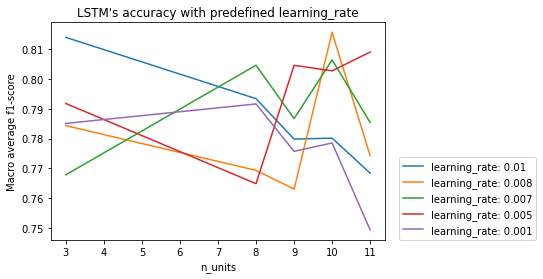

In [64]:
from utils.plot_utils import plot_score

macro_avg_f1_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['macro avg']['f1-score'][0],
                   'std': all_reports[z]['macro avg']['f1-score'][1]}),
    all_reports
))

plot_score(
    [macro_avg_f1_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Macro Average F1-Score'
)


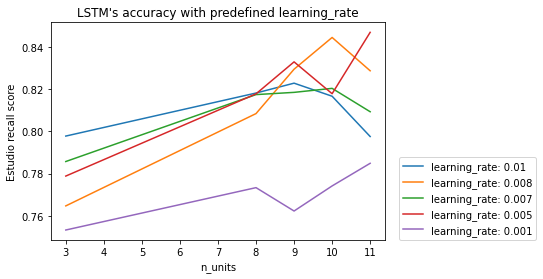

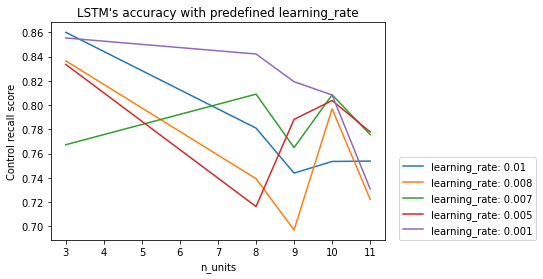

In [66]:
estudio_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['Estudio']['recall'][0],
                   'std': all_reports[z]['Estudio']['recall'][1]}),
    all_reports
))

control_recall_scores = dict(map(
    lambda z: (z, {'score': all_reports[z]['Control']['recall'][0],
                   'std': all_reports[z]['Control']['recall'][1]}),
    all_reports
))

plot_score(
    [estudio_recall_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Estudio recall score'
)

plot_score(
    [control_recall_scores],
    ('n_units', 'learning_rate'),
    'LSTM',
    inverse=False,
    mode='score',
    in_same_graphic=True,
    accuracy_mode='accuracy',
    metric_name='Control recall score'
)


# <font color=#cd0000> Conclusiones </font>
- TODO - Unas breves conclusiones sobre los resultados obtenidos (influencia de la codificación, ...)